In [ ]:
!pip install gluoncv mxnet d2l

In [ ]:
# we try to reduce model complexity by comparing its distance to zero.
# using different norms like l1 and l2.

# imagine a linear function: f(x) = w.T.x
# we could measure complexity with this formula: ||w ^ 2||
# the common method is adding this norm to the loss as a penalty term.
# this was the generilzied loss for linear regression

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

In [ ]:
# we add the penalty term via a regularization constant λ to the loss.

$$L(\mathbf{w}, b) + \frac{\lambda}{2} |\mathbf{w}|^2,$$

In [ ]:
# linear regression regularized by the l2 algorithm is called  ridge regression.
# whereas a one with l1 reg is called lasso regression.

In [2]:
# benefits of weight decay in an example.
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [4]:
def init_params():
  w = np.random.normal(scale=1, size=(num_inputs, 1))
  b = np.zeros(1)
  w.attach_grad()
  b.attach_grad()
  return [w, b]

In [5]:
def l2_penalty(w):
  return (w**2).sum() / 2

In [7]:
def train(lambd):
  w, b = init_params()
  net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
  num_epochs, lr = 100, 0.003
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
  xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        # The L2 norm penalty term has been added, and broadcasting
        # makes `l2_penalty(w)` a vector whose length is `batch_size`
        l = loss(net(X), y) + lambd * l2_penalty(w)
      l.backward()
      d2l.sgd([w, b], lr, batch_size)
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
      d2l.evaluate_loss(net, test_iter, loss)))
  print('L2 norm of w:', np.linalg.norm(w))

L2 norm of w: 13.259394


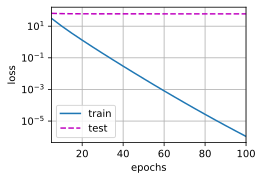

In [8]:
train(lambd=0)

L2 norm of w: 0.38249874


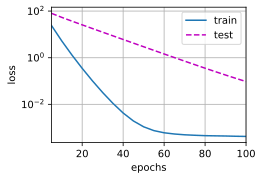

In [9]:
train(lambd=3)

In [10]:
def train_concise(wd):
  net = nn.Sequential()
  net.add(nn.Dense(1))
  net.initialize(init.Normal(sigma=1))
  loss = gluon.loss.L2Loss()
  num_epochs, lr = 100, 0.003
  trainer = gluon.Trainer(net.collect_params(), 'sgd',
                          {'learning_rate': lr, 'wd': wd})
  # The bias parameter has not decayed. Bias names generally end with "bias"
  net.collect_params('.*bias').setattr('wd_mult', 0)
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                          xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      with autograd.record():
        l = loss(net(X), y)
      l.backward()
      trainer.step(batch_size)
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                              d2l.evaluate_loss(net, test_iter, loss)))
  print('L2 norm of w:', np.linalg.norm(net[0].weight.data()))

L2 norm of w: 15.01407


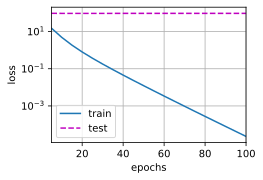

In [11]:
train_concise(0)

L2 norm of w: 0.339919


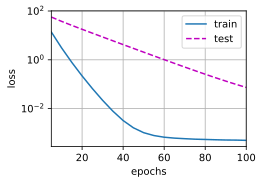

In [12]:
train_concise(3)